# Using neural networks for L96 parameterization

In [1]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import math


import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch_lr_finder import LRFinder
import torch.nn.functional as F

from sklearn.metrics import r2_score
np.random.seed(42) # For reproducibility 


In [2]:
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t  # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
from L96_model_XYtend import EulerFwd, RK2, RK4 

### Create GCM classes with and without neural network parameterization

In [3]:
time_method = RK4

In [4]:
#- a GCM class without any parameterization
class GCM_no_param:
    def __init__(self, F, time_stepping=time_method):
        self.F = F
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        return L96_eq1_xdot(X, self.F)
        
    def __call__(self,X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X,param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [6]:
#- a GCM class including a linear parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        return L96_eq1_xdot(X, self.F) -  self.parameterization(param,X)
        
    def __call__(self,X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X,param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [7]:
#- a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch,1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X,0)).double()
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy()) # Adding NN parameterization
        
    def __call__(self,X0, dt, nt , param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X, param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [8]:
# Setting the seed gives us reproducible results
np.random.seed(13)
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01*time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=Forcing)

#### Getting training data (input output pairs): 

In [9]:
# Get training data for the neural network. 

#- Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue,_,_,xytrue = W.run(dt, T,store=True)
gcm_no_param = GCM_no_param(Forcing)

#### Split to train and test (validation) data:

In [10]:
val_size = 4000 # number of time steps for validation


#train:
Xtrue_train = Xtrue[:-val_size,:] #Flatten because we first use single input as a sample
subgrid_tend_train = xytrue[:-val_size,:]

#test:
Xtrue_test = Xtrue[-val_size:,:]
subgrid_tend_test = xytrue[-val_size:,:]


## Using data loaders 

- ### Dataset and Dataloader classes provide a very convenient way of iterating over a dataset while training your machine learning model.

- ### We need to iterate over the data because it is very slow and memory intensive to hold all the data and to use gradient decent over all the data simultaneously (see more details [here](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

<!-- This provides a very convenient way of separating the data preparation part from the training procedure.  -->

In [11]:
# Define a data loader

#Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
local_torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_train,-1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_train,-1)).double()
)

BATCH_SIZE = 1024 # Number of sample in each batch

loader_local = Data.DataLoader(
        dataset=local_torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True)

In [12]:
# Define a test dataloader

local_torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_test,-1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_test,-1)).double()
)

loader_local_test = Data.DataLoader(
        dataset=local_torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True)

tensor([-1.1193, -5.6357, -5.0554,  ...,  2.6868,  3.5134,  5.4219],
       dtype=torch.float64)
tensor([ 3.4764,  3.9362,  7.8567,  ..., -4.1134, -3.7527, -6.6608],
       dtype=torch.float64)


Text(0, 0.5, 'subgrid tendency')

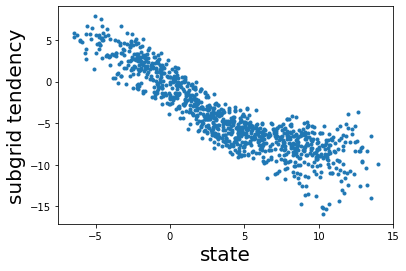

In [13]:
dataiter = iter(loader_local) # iterating over the data to get one batch
X_iter, subgrid_tend_iter = dataiter.next()

print(X_iter)
print(subgrid_tend_iter)

fontsize = 20
plt.plot(X_iter,subgrid_tend_iter,'.')
plt.xlabel('state',fontsize=fontsize)
plt.ylabel('subgrid tendency',fontsize=fontsize)

### Define network structure in pytorch 
If you want to learn more:

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

- ### Neural networks can have many different structures.
- #### Here we will consider fully connected networks
- #### To undersand fully connected networks, we only need to understand Linear regression (and gradient descent).



### First we will build a linear regression 'network' and later see how to generalize the linear regression in order to use Fully connected neural network. 

In [14]:
#define a network structure in pytorch (here it is a linear network)
class linear_reg(nn.Module):
    def __init__(self):
        super(linear_reg, self).__init__()
        self.linear1 = nn.Linear(1, 1) # a single input and a single output
    def forward(self, x): # when calling the model ('linear_reg(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
        x = self.linear1(x) 
        return x

In [15]:
lin_net = linear_reg().double()
print(lin_net)

linear_reg(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)


### Using the nework to get a prediction


In [16]:
# An example of how to plug a sample into the network
input1 = torch.randn(1, 1).double()
out = lin_net(input1) 
# when calling the model ('lin_net(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
print('The output of the random input is:',out.detach().numpy())



The output of the random input is: [[-0.62146085]]


### To adjust (optimize) the weights we need to define a loss function

In [17]:
criterion = torch.nn.MSELoss() # MSE loss function
X_tmp = next(iter(loader_local))

y_tmp = lin_net(torch.unsqueeze(X_tmp[0],1)) # Predict
loss = criterion(y_tmp, torch.unsqueeze(X_tmp[1],1)) #calculate the MSE loss loss



### Calculating gradients

In [18]:
lin_net.zero_grad() # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(lin_net.linear1.bias.grad)

loss.backward(retain_graph=True) #Computes the gradient of all components current tensor

print('conv1.bias.grad after backward')
print(lin_net.linear1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([9.1268], dtype=torch.float64)


### Updating the weights using optimizer (basically built in methods for optimization such as SGD, Adam and etc.)

In [19]:
optimizer = optim.SGD(lin_net.parameters(), lr=0.003, momentum=0.9)
print('Before backward pass: \n',list(lin_net.parameters())[0].data.numpy())
loss.backward(retain_graph=True) 
optimizer.step()
print('After backward pass: \n',list(lin_net.parameters())[0].data.numpy())

Before backward pass: 
 [[0.37080908]]
After backward pass: 
 [[-0.16728739]]


it’s crucial you choose the correct learning rate as otherwise your network will either fail to train, or take much longer to converge. [Here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) you can read more about the momentum term in SGD.

### The  effective value of the gradient (V) at step t in SGD with momentum ($\beta$):
### $V_t = \beta V_{t-1} + (1-\beta) \nabla_w L(W,X,y)$

### and the updates to the weights will be:
### $w^{new} = w^{old} - LR * V_t$

## Using - Adam (an adaptive learning rate optimization algorithm)

The choice of which optimizer we choose might be very important. It will determine how fast the network will be able to learn. Adam is a very popular choice (read more [here](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) about Adam). 

#### Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.


## Combining it all together:  training the whole network

In [20]:
def train_model(net,criterion,trainloader,optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x) # Inputs
        b_y = Variable(batch_y) # outputs
        if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)   # Calculating loss 
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
#         test_loss = test_loss + loss.data.numpy() # Keep track of the loss for convenience 
#     test_loss /= len(trainloader) # dividing by the number of batches
#     print('the loss in this Epoch',test_loss)
#     print(b_y.shape)
#     print(prediction.shape)


In [21]:
def test_model(net,criterion,trainloader,optimizer, text = 'validation'):
    net.eval() # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
            b_x = Variable(batch_x) # Inputs
            b_y = Variable(batch_y) # outputs
            if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)   # Calculating loss 
            test_loss = test_loss + loss.data.numpy() # Keep track of the loss 
        test_loss /= len(trainloader) # dividing by the number of batches
#         print(len(trainloader))
        print(text + ' loss:',test_loss)
    return test_loss


In [22]:
n_epochs = 3 #Number of epocs (the number of times we iterate over the training data during training)
optimizer = optim.Adam(lin_net.parameters(), lr=0.03) # If we have time we can discuss later the Adam optimizer
for epoch in range(1, n_epochs + 1):
    train_model(lin_net,criterion,loader_local,optimizer)
    test_model(lin_net,criterion,loader_local,optimizer, 'train')
    test_model(lin_net,criterion,loader_local_test,optimizer)

train loss: 4.021677254886284
validation loss: 3.946774786182778
train loss: 3.98519358417721
validation loss: 3.934704492949506
train loss: 4.01128514048472
validation loss: 3.936996959339057


In [23]:
print(lin_net.linear1.weight.data.numpy())
print(lin_net.linear1.bias.data.numpy())

[[-0.84587213]]
[-0.74007655]


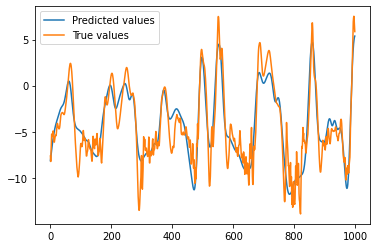

In [24]:
preds22 = lin_net(torch.unsqueeze(torch.from_numpy(np.reshape(Xtrue_test[:,1],-1)).double(),1))
plt.plot(preds22.detach().numpy()[0:1000], label='Predicted values')
plt.plot(subgrid_tend_test[:1000,1], label='True values');

plt.legend();

In [25]:
T_test = 10

X_full,_,_,_ = W.run(dt, T_test) # Full model


init_cond = Xtrue[-1,:]

gcm_net = GCM_network(Forcing,lin_net)
Xnn_1layer,t = gcm_net(init_cond ,dt, int(T_test/dt),lin_net)

gcm_no_param = GCM_no_param(Forcing)
X_no_param,t = gcm_no_param(init_cond ,dt, int(T_test/dt))


naive_parameterization= lambda param,X : np.polyval(param,X)
gcm = GCM (Forcing,naive_parameterization)
X_param,t = gcm(init_cond,dt, int(T/dt), param=[0.85439536, 1.75218026])

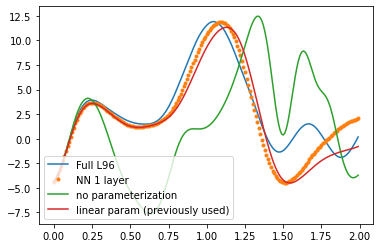

In [27]:
time_i = 200
plt.plot(t[:time_i], X_full[:time_i,4], label='Full L96');
plt.plot(t[:time_i], Xnn_1layer[:time_i,4],'.', label='NN 1 layer');
plt.plot(t[:time_i], X_no_param[:time_i,4], label='no parameterization');
plt.plot(t[:time_i], X_param[:time_i,4], label='linear param (previously used)');

plt.legend();

# Using a deeper network  for the Lorenz96  (and using non local features)

## Create non-local train/test data sets (8 inputs, 8 outputs)

In [28]:
# Create non local training data 
# Define a data loader (8 inputs, 8 outputs)

#Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(Xtrue_train).double(),
    torch.from_numpy(subgrid_tend_train).double()
)

BATCH_SIZE = 1024 # Number of sample in each batch

loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True)




In [29]:
# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(Xtrue_test).double(),
    torch.from_numpy(subgrid_tend_test).double()
)

loader_test = Data.DataLoader(
        dataset=torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True)

## Creating a class of a 3 layer fully-connected network

In [30]:
#define network structure in pytorch 
import torch.nn.functional as FF

class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
#         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

## Activation function - ReLU (a popular choice)

### If layers would contain only matrix multiplication, everything would be linear: 
- ### e.g., 2 layers of weight matrices  A and B (x is the input) would give $A(Bx)$, which is linear (in x)
- ### Therefore we need to introduce some non-linearity (activation function). 
- ### The Neural Network with 2 layers of weight matrices  A and B is actually:
### $A(\phi(Bx))$ where $\phi$ is an actication function


The ReLu ativation function is just the max(0,X) - and this what is enabling the NN to be a nonlinear function of the inputs!

Text(0.5, 1.0, 'ReLU')

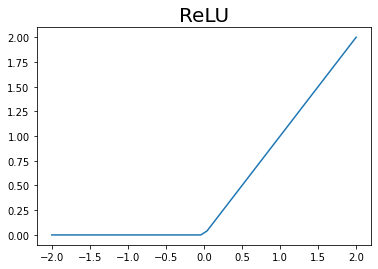

In [52]:
x = np.linspace(-2,2,50)
plt.plot(x,np.maximum(x,0))
plt.title('ReLU',fontsize = 20)

In [31]:
nn_3l = Net_ANN().double()

### Train:

train loss: 28.577426556958915
validation loss: 28.557747571821466
train loss: 18.250131789777527
validation loss: 18.095657943865103
train loss: 12.712647881433421
validation loss: 12.66049110914684
train loss: 9.236061866488393
validation loss: 9.211456913349986
train loss: 7.873759347799311
validation loss: 7.856166089086212
train loss: 7.084115499342736
validation loss: 7.15230897478159
train loss: 6.172420275037979
validation loss: 6.288116016965486
train loss: 5.374717368066813
validation loss: 5.4927173498797774
train loss: 4.83446564913548
validation loss: 4.956984679443533
train loss: 4.415877244168698
validation loss: 4.542114194926988
train loss: 3.9319705139912156
validation loss: 4.061158791324305
train loss: 3.481907923138365
validation loss: 3.5979798008860966
train loss: 3.197512544530882
validation loss: 3.2880475772862328
train loss: 3.0615715574729236
validation loss: 3.1414499976276677
train loss: 2.9900306507934404
validation loss: 3.0732391771657044
train loss: 2.

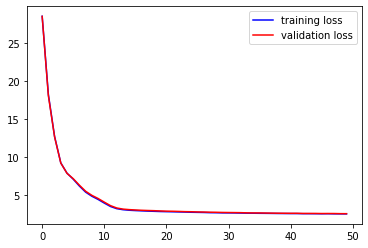

In [32]:
n_epochs = 50 #Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

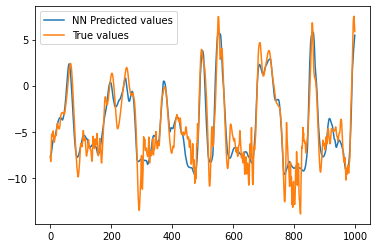

In [34]:
preds22 = nn_3l(torch.from_numpy(Xtrue_test[:,:]).double())
plt.plot(preds22.detach().numpy()[0:1000,1], label='NN Predicted values')
plt.plot(subgrid_tend_test[:1000,1], label='True values');

plt.legend();

In [35]:
T_test = 5

# X_full,_,_,_ = W.run(dt, T_test) # Full model


# init_cond = Xtrue[-1,:]

gcm_net_3layers = GCM_network(Forcing,nn_3l)
Xnn_3layer,t = gcm_net_3layers(init_cond ,dt, int(T_test/dt),nn_3l)

gcm_net_1layers = GCM_network(Forcing,lin_net)
Xnn_1layer,t = gcm_net_1layers(init_cond ,dt, int(T_test/dt),lin_net)

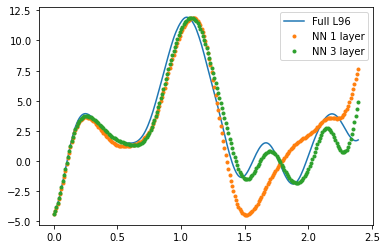

In [36]:
time_i = 240
plt.plot(t[:time_i], X_full[:time_i,4], label='Full L96');
plt.plot(t[:time_i], Xnn_1layer[:time_i,4],'.', label='NN 1 layer');
plt.plot(t[:time_i], Xnn_3layer[:time_i,4],'.', label='NN 3 layer');

plt.legend();

### Training some more to further improve performance

train loss: 2.5015920856669034
validation loss: 2.534167250404571
train loss: 2.5066111649643172
validation loss: 2.5338273672086102
train loss: 2.496012297623264
validation loss: 2.523819257021529
train loss: 2.498591164969459
validation loss: 2.5243692193640968
train loss: 2.504537741191542
validation loss: 2.5303028575375714
train loss: 2.4880646446851324
validation loss: 2.512197265930801
train loss: 2.4864817666988097
validation loss: 2.5223446260263223
train loss: 2.480229126740727
validation loss: 2.5100358961566283
train loss: 2.47748671695294
validation loss: 2.5106050350067717
train loss: 2.4767977279059794
validation loss: 2.5066286551222223
train loss: 2.4772267023735193
validation loss: 2.5012451604000407
train loss: 2.4692781877402092
validation loss: 2.5016035419578966
train loss: 2.4676378662374114
validation loss: 2.502545914587162
train loss: 2.4667247352971726
validation loss: 2.501657220387975
train loss: 2.4652212024887823
validation loss: 2.4960730833865115
train 

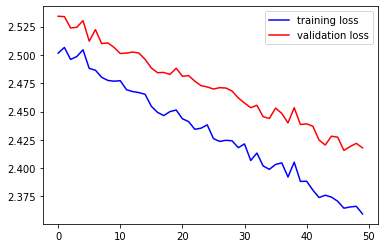

In [37]:
n_epochs = 50 #Number of epocs
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

In [39]:
# T_test = 5

# gcm_net_3layers = GCM_network(Forcing,nn_3l)
# Xnn_3layer,t = gcm_net_3layers(init_cond ,dt, int(T_test/dt),nn_3l)

# gcm_net_1layers = GCM_network(Forcing,lin_net)
# Xnn_1layer,t = gcm_net_1layers(init_cond ,dt, int(T_test/dt),lin_net)

# time_i = 240
# plt.plot(t[:time_i], X_full[:time_i,4], label='Full L96');
# plt.plot(t[:time_i], Xnn_1layer[:time_i,4],'.', label='NN 1 layer');
# plt.plot(t[:time_i], Xnn_3layer[:time_i,4],'.', label='NN 3 layer');

# plt.legend();

In [45]:
# Save network
PATH = '/Users/yani/Dropbox/MIT/m2lines/L96_demo/networks/network_3_layers_100_epoches.pth'
torch.save(nn_3l.state_dict(), PATH)

#Load network
# path_load = '/Users/yani/Dropbox/MIT/m2lines/L96_demo/networks/network_3_layers_100_epoches.pth'
# nn_3l.load_state_dict(torch.load(path_load))


# Regularization and overfitting

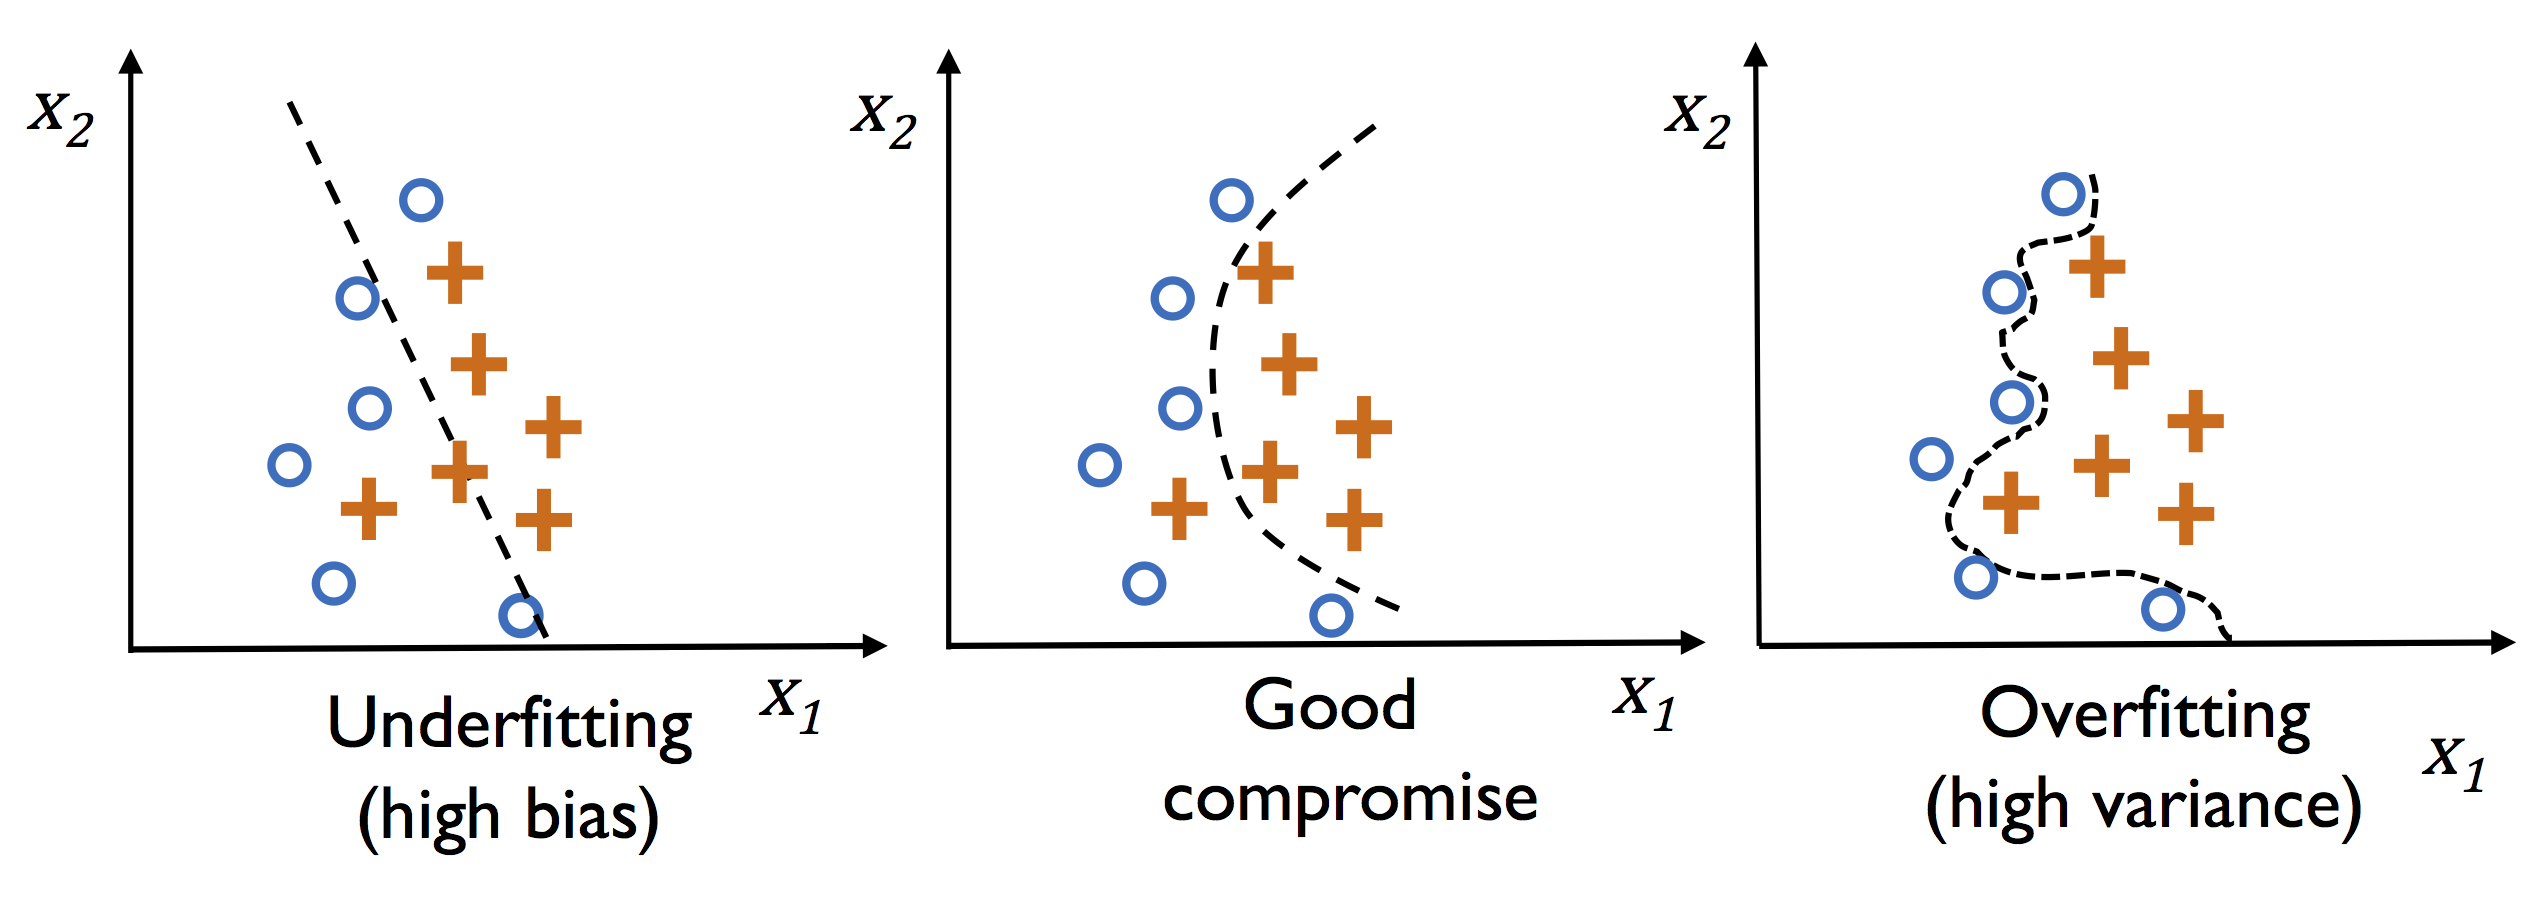

In [40]:
from IPython.display import Image
Image(filename='figs/overfitting.png', width=700)
# The figure below is taken from Python Machine Learning book by Sebastian Raschka


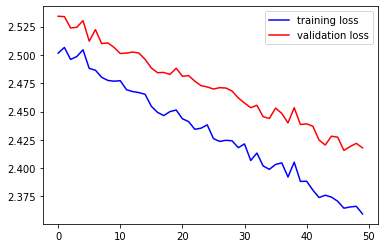

In [41]:
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

### Regularization methods are aimed to tackle overfitting. 

For example, the model on the far right of the plot predicts perfectly on the given set, yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.



All ML algorithms has some form of regularization. 

### Useful ways to think of regularization:
- #### Putting constraints on the model
aiming to have a better generalizability (avoid modeling the noise or ''remember'' training data). 
- #### Adding a term to the loss function so that: Loss = TrainingLoss + Regularization
put a penalty for making the model more complex. 


Very braodly speaking (just to gain intuition) - if we want to reduce the training loss (reduce bias) we should try using a more complex model (if we have enough data) and if we want to reduce overfitting (reduce variace) we should simplify or constraint the model we use (increasing regularization). 


# Regularization of Neural Networks

- Dropout (added in the definition of the network). 
- Early stopping
- weight decay (added in the optimizer part - see ?optim.Adam)
- Data augmentation (usually for images)

#### Weight decay (L2 norm)

weight decay is usually defined as a term that’s added directly to the update rule.
Namely, to update a certain weight $w$ in the $i+1$ iteration, we would use a modified rule:

$w_{i+1} = w_{i} - \gamma (A w_{i} + \frac{\partial L}{\partial w})$

In practice, this is almost identical to L_2 regularization, though there is some difference (e.g., see [here](https://bbabenko.github.io/weight-decay/))

Weight decay is one of the parameters of the optimizer - try ?torch.optim.SGD

### Add a weight decay to a network and try to train it again

train loss: 2.40802405442132
validation loss: 2.459986352107622
train loss: 2.402242631943656
validation loss: 2.471248997527266
train loss: 2.423290765948023
validation loss: 2.4835034338865554
train loss: 2.4323151902985822
validation loss: 2.4856381200963678
train loss: 2.4438636164664143
validation loss: 2.4961034869248944
train loss: 2.4613824209689166
validation loss: 2.5059642845813737
train loss: 2.463120132474525
validation loss: 2.5126222432840546
train loss: 2.4732779145878387
validation loss: 2.512773954478813
train loss: 2.478853526232998
validation loss: 2.5266780613913378
train loss: 2.487374191216992
validation loss: 2.530327805596916


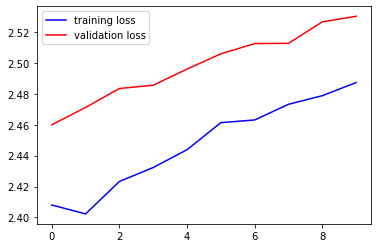

In [42]:
n_epochs = 10 #Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003,weight_decay=0.1)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

#### Dropout

By dropping a unit out, we mean temporarily removing it from the network while training, along with all its incoming and outgoing connections. 
See more details [here](http://jmlr.org/papers/v15/srivastava14a.html).
It is usually the most useful regularization that we can do in fully connected layers

In convolutional layers dropout makes less sense - see more discussion [here](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html)


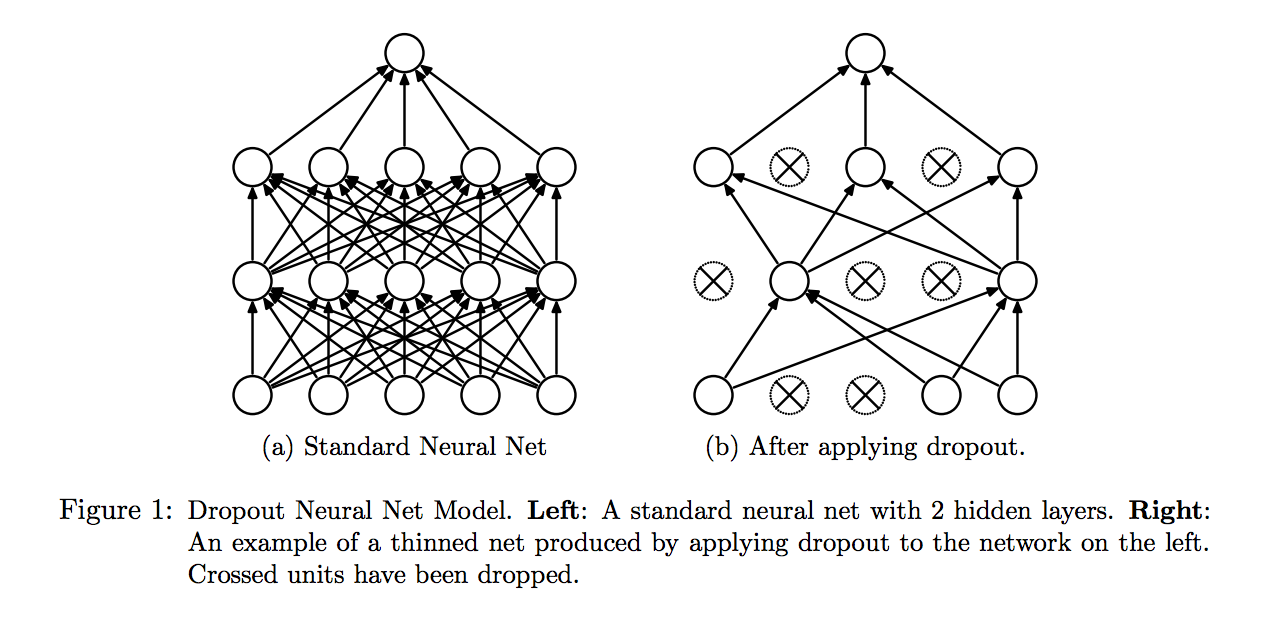

In [43]:
#Image taken from: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
Image(filename='figs/Dropout_layer.png', width=700)




In [44]:
#define network structure in pytorch 

class Net_ANN_dropout(nn.Module):
    def __init__(self,dropout= 0.2):
        super(Net_ANN_dropout, self).__init__()
        self.linear1 = nn.Linear(8, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.drop = nn.Dropout(dropout) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = self.drop(x)
        x = FF.relu(self.linear2(x))
        x = self.drop(x)
        x = self.linear3(x)
        return x

train loss: 24.717012291270795
validation loss: 24.635259621431906
train loss: 22.82612442342762
validation loss: 22.716197770704564
train loss: 20.604022927308083
validation loss: 20.549013183684046
train loss: 19.59872502444889
validation loss: 19.60123374663133
train loss: 18.228317533229465
validation loss: 18.24590837686109
train loss: 17.742801479957283
validation loss: 17.74453101896822
train loss: 16.632064670330184
validation loss: 16.591805029820176
train loss: 16.17522878438091
validation loss: 16.110723065281487
train loss: 16.200623678426364
validation loss: 16.13824083942375
train loss: 15.867795312511841
validation loss: 15.818354342676116


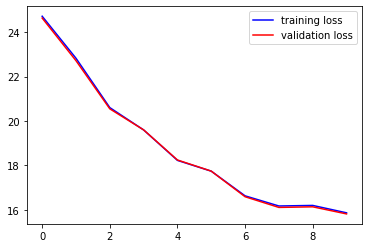

In [49]:
nn_3l_drop = Net_ANN_dropout(dropout = 0.8).double() #Exagerated dropout... 
n_epochs = 10 #Number of epocs
optimizer = optim.Adam(nn_3l_drop.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_drop,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_drop,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_drop,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

# How to choose a learning rate?

### Visuzlization of the loss function

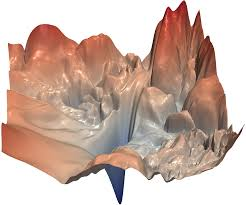

In [50]:
#Image taken from: https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf
Image(filename='figs/Loss_function_vis_NN.jpeg', width=400)


## Finding an optimal learning rate


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.43E-02


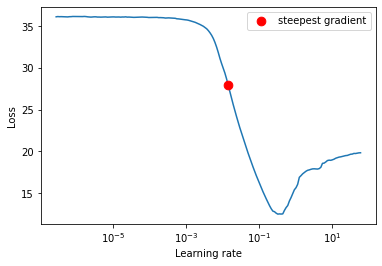

In [51]:
nn_3l_LR = Net_ANN().double()
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

train loss: 16.54324316700128
validation loss: 16.574219597357867
train loss: 8.773177316803814
validation loss: 8.825049091258133
train loss: 6.72365031122252
validation loss: 6.751831118324924
train loss: 5.137905166176448
validation loss: 5.220413362752657
train loss: 3.986117074622757
validation loss: 4.078631471856238
train loss: 3.4324056640696368
validation loss: 3.5402201531165174
train loss: 3.092852400781261
validation loss: 3.2086491975049682
train loss: 2.9554548914457106
validation loss: 3.067727807427123
train loss: 2.8523120341483392
validation loss: 2.9294718913926667
train loss: 2.800712873359794
validation loss: 2.863317643327726
train loss: 2.7343278533491913
validation loss: 2.8065261716873735
train loss: 2.6769286883442036
validation loss: 2.739045983640529
train loss: 2.656664256673283
validation loss: 2.709191858935963
train loss: 2.612983204710419
validation loss: 2.6678577803805434
train loss: 2.590818714345042
validation loss: 2.644836326529937
train loss: 2.5

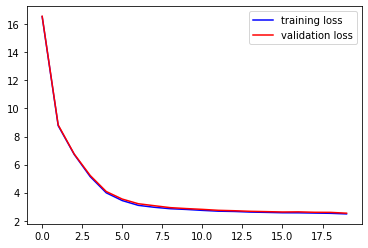

In [72]:
n_epochs = 20 #Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_LR,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_LR,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

### We converged much faster than before. 

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.07E-05


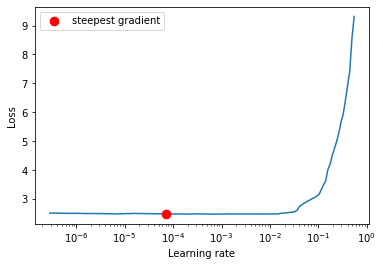

In [73]:
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

train loss: 2.4721981520219654
validation loss: 2.5238393844722142
train loss: 2.464160928839938
validation loss: 2.517748355908843
train loss: 2.4646391207040987
validation loss: 2.5154425804887026
train loss: 2.4591320955019396
validation loss: 2.508125009712474
train loss: 2.458303401852505
validation loss: 2.506920563677752
train loss: 2.455366423267751
validation loss: 2.5020112060483024
train loss: 2.4502609679046228
validation loss: 2.4996496109205415
train loss: 2.44639871714295
validation loss: 2.4955657566902434
train loss: 2.4447902922576605
validation loss: 2.4977546144928318
train loss: 2.4414817349277085
validation loss: 2.493863427058754


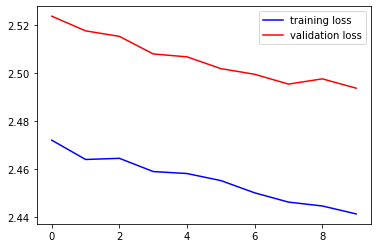

In [74]:
n_epochs = 10 #Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.001)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l_LR,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l_LR,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

## I won't talk about but I recommend reading:

## BatchNormalization 

Normalize the activation values such that the hidden representation doesn’t vary drastically and also helps us to get improvement in the training speed.

## Cyclic learning rate

### To understand cyclic learning rates and the One cycle policy - read more [here](https://sgugger.github.io/the-1cycle-policy.html)

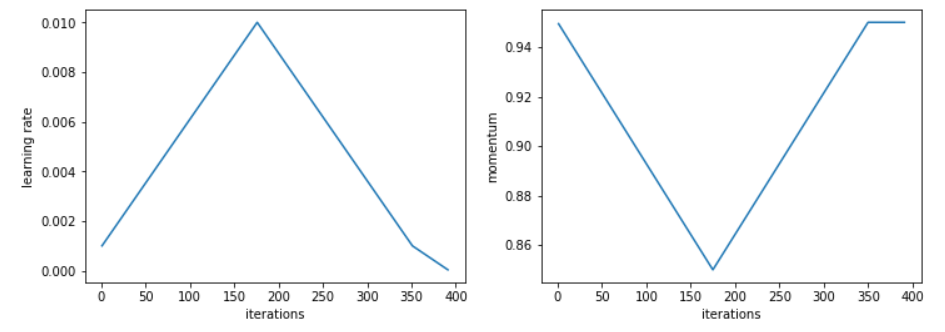

In [76]:
# Image taken from - https://docs.fast.ai/callbacks.one_cycle.html
Image(filename='figs/onecycle_params.png', width=700)

To use cyclic learning rates: ?optim.lr_scheduler.CyclicLR